# ISIC Dataset Preprocessing

This notebook preprocesses the ISIC 2018 Task 1 dataset for skin lesion segmentation.

**Steps:**
1. Load raw images and masks
2. Resize to 256x256
3. Normalize images
4. Ensure masks are binary
5. Create train/val/test splits
6. Save processed data

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## 1. Configuration

In [2]:
# Paths
RAW_IMAGES_DIR = '../data/raw/isic/images'
RAW_MASKS_DIR = '../data/raw/isic/masks'

PROCESSED_IMAGES_DIR = '../data/processed/isic/images'
PROCESSED_MASKS_DIR = '../data/processed/isic/masks'

# Create directories
os.makedirs(PROCESSED_IMAGES_DIR, exist_ok=True)
os.makedirs(PROCESSED_MASKS_DIR, exist_ok=True)

# Parameters
TARGET_SIZE = (256, 256)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
RANDOM_SEED = 42

## 2. Load and Inspect Raw Data

In [3]:
# Get list of images and masks
image_files = sorted([f for f in os.listdir(RAW_IMAGES_DIR) if f.endswith(('.jpg', '.png'))])
mask_files = sorted([f for f in os.listdir(RAW_MASKS_DIR) if f.endswith('.png')])

print(f"Found {len(image_files)} images")
print(f"Found {len(mask_files)} masks")

# Match images with masks
# Assuming masks have '_segmentation' suffix or similar
# Adjust this based on your actual file naming convention
image_mask_pairs = []

for img_file in image_files:
    # Extract base name (without extension)
    base_name = os.path.splitext(img_file)[0]
    
    # Find corresponding mask
    # Try different naming conventions
    possible_mask_names = [
        f"{base_name}_segmentation.png",
        f"{base_name}.png",
        f"{base_name}_mask.png"
    ]
    
    for mask_name in possible_mask_names:
        if mask_name in mask_files:
            image_mask_pairs.append((img_file, mask_name))
            break

print(f"\nMatched {len(image_mask_pairs)} image-mask pairs")

Found 3694 images
Found 2594 masks

Matched 2594 image-mask pairs


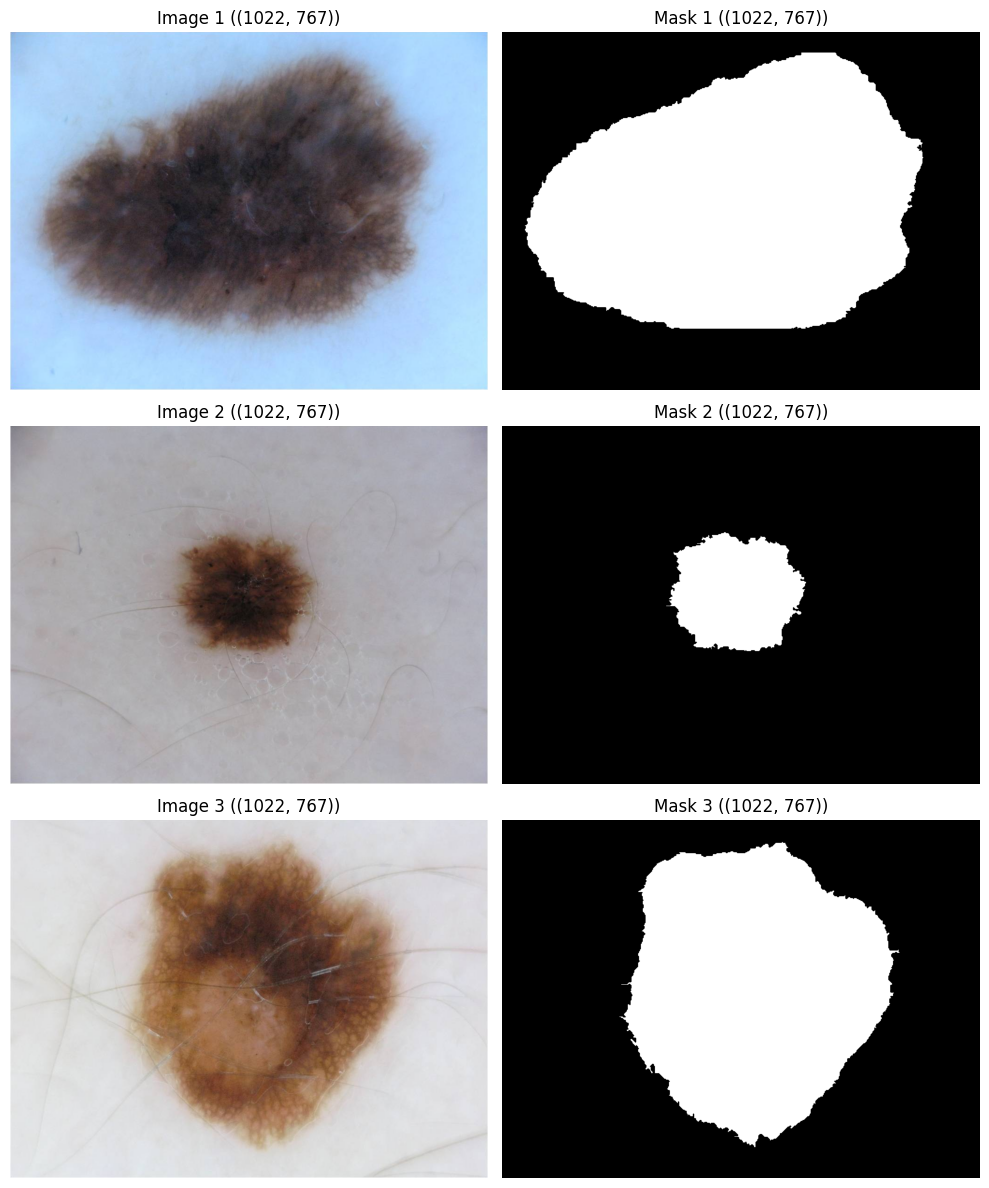

In [4]:
# Visualize a few samples
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i in range(3):
    img_file, mask_file = image_mask_pairs[i]
    
    # Load image and mask
    img = Image.open(os.path.join(RAW_IMAGES_DIR, img_file))
    mask = Image.open(os.path.join(RAW_MASKS_DIR, mask_file))
    
    # Display
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Image {i+1} ({img.size})')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f'Mask {i+1} ({mask.size})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

## 3. Preprocess and Save Data

In [5]:
def preprocess_image(img_path, output_path, target_size=(256, 256)):
    """
    Load, resize, and save image.
    """
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size, Image.BILINEAR)
    img.save(output_path)
    return img

def preprocess_mask(mask_path, output_path, target_size=(256, 256)):
    """
    Load, resize, binarize, and save mask.
    """
    mask = Image.open(mask_path).convert('L')
    mask = mask.resize(target_size, Image.NEAREST)  # Use NEAREST for masks
    
    # Binarize (threshold at 127)
    mask_array = np.array(mask)
    mask_array = (mask_array > 127).astype(np.uint8) * 255
    
    mask = Image.fromarray(mask_array)
    mask.save(output_path)
    return mask

In [6]:
# Process all images and masks
processed_pairs = []

print("Processing images and masks...")
for img_file, mask_file in tqdm(image_mask_pairs):
    # Generate output filenames
    base_name = os.path.splitext(img_file)[0]
    
    output_img_name = f"{base_name}.png"
    output_mask_name = f"{base_name}_mask.png"
    
    output_img_path = os.path.join(PROCESSED_IMAGES_DIR, output_img_name)
    output_mask_path = os.path.join(PROCESSED_MASKS_DIR, output_mask_name)
    
    # Preprocess
    try:
        preprocess_image(
            os.path.join(RAW_IMAGES_DIR, img_file),
            output_img_path,
            TARGET_SIZE
        )
        
        preprocess_mask(
            os.path.join(RAW_MASKS_DIR, mask_file),
            output_mask_path,
            TARGET_SIZE
        )
        
        processed_pairs.append((output_img_path, output_mask_path))
    except Exception as e:
        print(f"Error processing {img_file}: {e}")

print(f"\nProcessed {len(processed_pairs)} pairs successfully")

Processing images and masks...


100%|██████████| 2594/2594 [1:54:04<00:00,  2.64s/it]  



Processed 2594 pairs successfully


## 4. Create Train/Val/Test Splits

In [7]:
# Create DataFrame
df = pd.DataFrame(processed_pairs, columns=['image_path', 'mask_path'])

# Split into train/temp
train_df, temp_df = train_test_split(
    df, 
    test_size=(VAL_RATIO + TEST_RATIO), 
    random_state=RANDOM_SEED
)

# Split temp into val/test
val_df, test_df = train_test_split(
    temp_df,
    test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
    random_state=RANDOM_SEED
)

# Add split column
train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

# Combine
splits_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print(f"Train samples: {len(train_df)}")
print(f"Val samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Total: {len(splits_df)}")

Train samples: 1815
Val samples: 389
Test samples: 390
Total: 2594


In [8]:
# Save splits CSV
splits_csv_path = '../data/processed/isic/splits.csv'
splits_df.to_csv(splits_csv_path, index=False)
print(f"\nSplits saved to: {splits_csv_path}")

# Display first few rows
splits_df.head()


Splits saved to: ../data/processed/isic/splits.csv


,image_path,mask_path,split
0,../data/processed/isic/images\ISIC_0016024.png,../data/processed/isic/masks\ISIC_0016024_mask...,train
1,../data/processed/isic/images\ISIC_0000026.png,../data/processed/isic/masks\ISIC_0000026_mask...,train
2,../data/processed/isic/images\ISIC_0000175.png,../data/processed/isic/masks\ISIC_0000175_mask...,train
3,../data/processed/isic/images\ISIC_0013423.png,../data/processed/isic/masks\ISIC_0013423_mask...,train
4,../data/processed/isic/images\ISIC_0000386.png,../data/processed/isic/masks\ISIC_0000386_mask...,train


## 5. Create Small Split for Debugging

In [9]:
# Create small subset (100-200 samples)
small_train = train_df.sample(n=min(100, len(train_df)), random_state=RANDOM_SEED)
small_val = val_df.sample(n=min(30, len(val_df)), random_state=RANDOM_SEED)
small_test = test_df.sample(n=min(30, len(test_df)), random_state=RANDOM_SEED)

small_splits_df = pd.concat([small_train, small_val, small_test], ignore_index=True)

# Save small splits
small_splits_csv_path = '../data/processed/isic/splits_small.csv'
small_splits_df.to_csv(small_splits_csv_path, index=False)

print(f"Small split created:")
print(f"  Train: {len(small_train)}")
print(f"  Val: {len(small_val)}")
print(f"  Test: {len(small_test)}")
print(f"\nSaved to: {small_splits_csv_path}")

Small split created:
  Train: 100
  Val: 30
  Test: 30

Saved to: ../data/processed/isic/splits_small.csv


## 6. Verify Processed Data

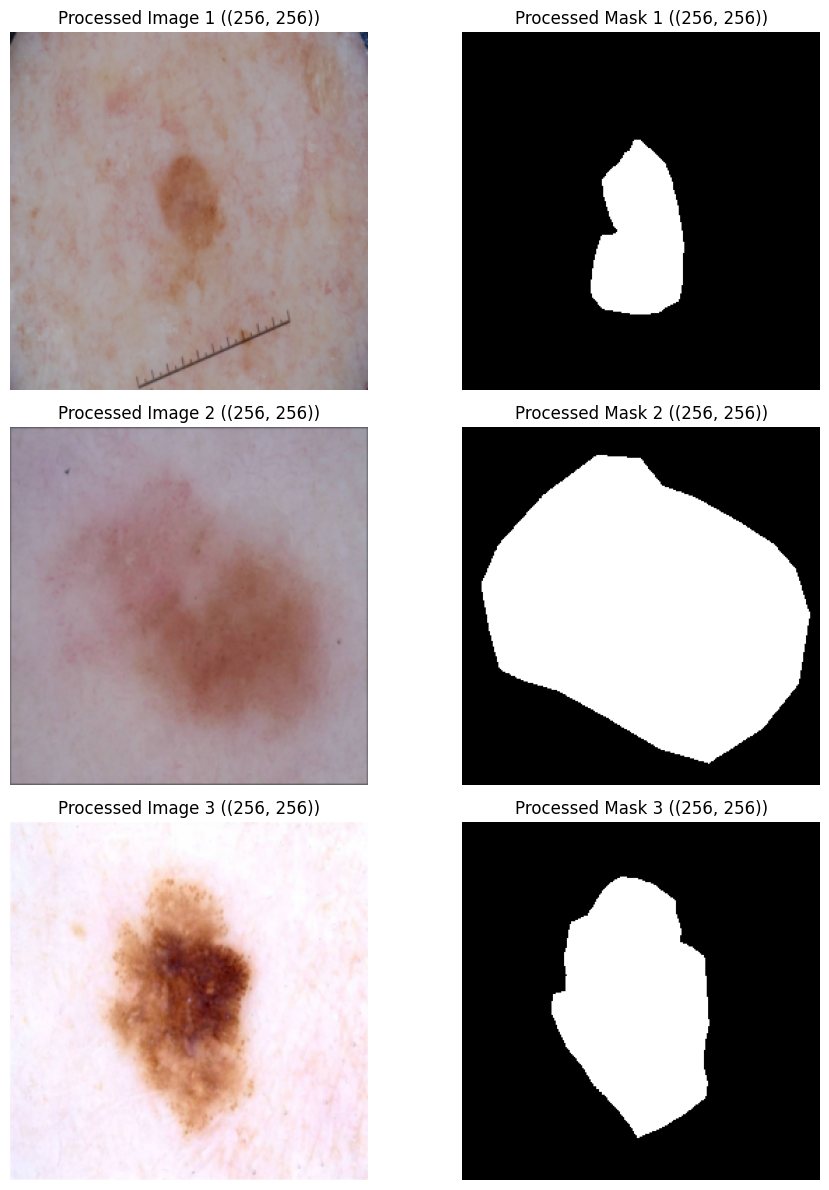

In [10]:
# Visualize processed samples
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i in range(3):
    row = splits_df.iloc[i]
    
    # Load processed image and mask
    img = Image.open(row['image_path'])
    mask = Image.open(row['mask_path'])
    
    # Display
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Processed Image {i+1} ({img.size})')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].set_title(f'Processed Mask {i+1} ({mask.size})')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

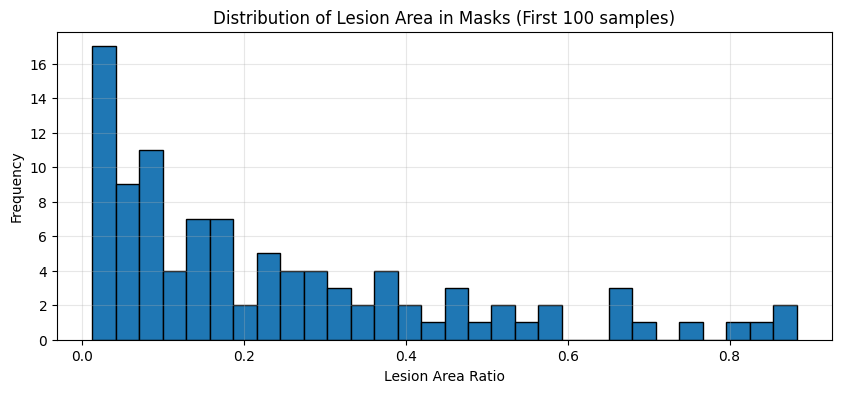

Mean lesion area ratio: 0.240
Std lesion area ratio: 0.221


In [11]:
# Check mask statistics
mask_ratios = []

for _, row in splits_df.head(100).iterrows():
    mask = np.array(Image.open(row['mask_path']))
    ratio = (mask > 127).sum() / mask.size
    mask_ratios.append(ratio)

plt.figure(figsize=(10, 4))
plt.hist(mask_ratios, bins=30, edgecolor='black')
plt.xlabel('Lesion Area Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Lesion Area in Masks (First 100 samples)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean lesion area ratio: {np.mean(mask_ratios):.3f}")
print(f"Std lesion area ratio: {np.std(mask_ratios):.3f}")

## Summary

✅ **Preprocessing completed!**

**Next steps:**
1. Zip the `data/processed/isic/` folder
2. Upload to Google Drive as `isic_processed_256.zip`
3. Push code to GitHub
4. Continue with training in Google Colab